# Causal inference with DoWhy

Jitao David Zhang, adapted from the [Quickstart tutorial of DoWhy](https://microsoft.github.io/dowhy/example_notebooks/tutorial-causalinference-machinelearning-using-dowhy-econml.html), November 2021.

## Setup

In [1]:
## required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets
from IPython.display import Image, display
import os

## setting appropriate log/warning level
import logging
import warnings
from sklearn.exceptions import DataConversionWarning
logging.getLogger("dowhy").setLevel(logging.WARNING)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## for estimation with EconML
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Simulate data
data = dowhy.datasets.linear_dataset(
    beta=8, ## the true causal effect
    num_common_causes=3,
    num_instruments=2,
    num_samples=5000,
    treatment_is_binary=True)
print(data["df"])

       Z0        Z1        W0        W1        W2     v0         y
0     1.0  0.837259 -0.395129 -1.799610 -1.351144   True -0.784172
1     1.0  0.477086  0.382205 -2.994367 -0.274757   True -2.739608
2     0.0  0.580271  0.355604 -2.017578 -1.038663   True -0.640631
3     1.0  0.122054  0.804288 -0.596805  0.411247   True  7.007251
4     0.0  0.140012  0.834496  0.791825 -1.441103   True  8.710545
...   ...       ...       ...       ...       ...    ...       ...
4995  0.0  0.082940 -0.404577 -1.101885 -0.412220  False -4.751625
4996  0.0  0.970771 -0.757268 -2.900505  1.028887   True -0.751391
4997  0.0  0.126145 -0.183822 -1.130745 -0.325476  False -4.585672
4998  1.0  0.059718  0.310194 -0.981639  1.736881   True  7.665289
4999  1.0  0.151852 -0.209015 -0.507616  0.009626   True  6.137256

[5000 rows x 7 columns]


## Step 1: Modelling

The first step of causal inference is to encode our domain knowledge into a causal model, often represented as a network of nodes and edges. The network, known as graph, encodes variables and their dependencies.

The outcome of causal inference critically depends on the input assumptions, so this step is important.

1. *Confounders*: forks that affect both action and outcome
2. *Instrumental variables*: start of the chain of IV-action-outcome, and not affected by any variable that affects the outcome.

In [3]:
# A causal model from domain knowledge
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"])
model.summary()

"Model to find the causal effect of treatment ['v0'] on outcome ['y']"

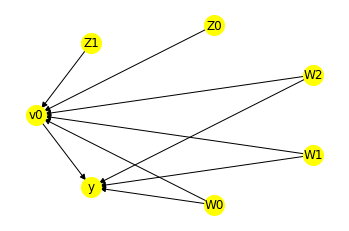

In [4]:
# visualize the graph
model.view_model(layout="dot")
#display(Image(filename="causal_model.png"))

graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"]]


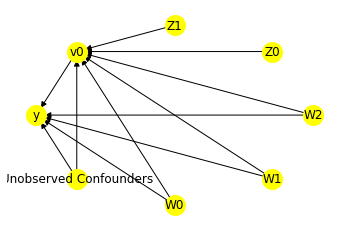

In [5]:
## In the example baove, domain knowledge is specified with named variable sets of confounders and IVs
## Alternatively, once and use a causal graph, like the example below shows
print(data["gml_graph"])
model_by_graph = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model_by_graph.view_model(layout="dot")

## Step 2: Identification

Once both the underlying causal graph is setup and the question of interest is identified (for instance the effect of A on B) during the modelling step, we can proceed to the *identification* step. The goal of *identification* is to check whether the target quantity can be estimated given the observed variables, also known as the identifiability of the model. The check is performed based on the model alone: it has *no need* to access the data itself. In another word, once the model is setup, its identifiability can be checked before the data is observed.

There are two main identification methods for causal inference, *the backdoor criterion* and *instrumental variable (IV) identification*.

The backdoor criterion, more generally known as *adjustment sets*, makes the following assertion: if all common causes of the action A and the outcome Y are observed, the causal effect from A to Y can be identified by conditioning on all the common causes (i.e. the confounders).

Here is an example of backdoor criterion. Let's assume that we want to estimate the effect of having a big lunch on Sunday on going for a walk in the afternoon. And let's assume that the weather is the only factor that affects both variables: good weather makes us attempt to eat much and to go for a walk, while bad weather decreases both the appetite and the interest of going outside. By measuring the food intake and the afternonon activity only, we may likely observe a observation, which is confounded by the weather. By observing the weather and investigating the relationship between food instake and afternoon activity conditional on the weather, we can better estimate the effect with the backdoor criterion.

Besides the background criterion, if an instrumental variable is available, we can estimate the effect of the action A and the outocme Y even when confounders of action and outcome are unobserved. Following the definition of instrumental variable above, an instrument only affects the action directly, and is not affected by any variable that also affects the outcome. Therefore, the effect of the instrument on the outcome is achieve in two sequential steps: the effect of the instrument on the action, and the effect of the action on the treatment. By estimating the effect of instrument on the action, and the effect of instrument on the outcome, we can learn indirectly the effect of the action on the outcome. 

Instrumental variable is often considered as 'natural experiments', because it is not affected by any causes of the outcome, and exerts its effect on the outcome only through the action. An example in the genomics field is *cis*-eQTL (expression quantitative traits loci), which is a single-nucleotide polymorphism (SNP) that affects the expression of a nearby gene. Whether an individual has two copies of the major allele, one copy of the major allele and one copy of the minor allele, or two copies of minor alleles is up to the random process of chromosome separation in the meiosis and mating of sperms and eggs. Now, if the nearby gene affects a phenotype (say risk of developing a disease), and there is no other genetic or environmental factors that affects both the SNP and the phenotype, then we can use the observations of SNPs, expression of the nearby gene, and phenotypes in a population to estimate the causal effect of the gene on the phenotype, treating the SNP as an instrumental variable.

In the case of binary instrument Z, the effect of action A on outcome Y is estimated by the ratio of the difference of outcome given the two versions of the instrument over the difference of action given the two versions of the instrument. This is because an instrument variable, such as in a natural experiment, causes changes in the outcome *via* the changes in the action. Therefore, the effect of action on the outcome is the amount of change in the outcome caused by the instrument divided by the amount of change in the action caused by the action.

$$
E[Y|do(A=1)] - E[Y|do(A=0)] = \frac{E[Y|Z=1]-E[Y|Z=0]}{E[A|Z=1]-E[A|Z=0]}
$$

In [6]:
## Identify causal effects and return target estimands
## The estimation trinity: Father (Estimand), Son (Estimate), and Holy Spirit (Estimator)
## Estimand (target of inference): a quantity that is to be estimated in a statistical analysis.
## Related concepts:
## Estimator (rule of inference): the rule for calculating an estimate of a given quantity based on observed data
## Estimate (result of inference): the specific numeric value obtained from a given method and dataset
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(Expectation(y|W1,W0,W2))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,U) = P(y|v0,W1,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative
([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Another estimand is using the frontdoor criterion and frontdoor adjustment. It will be explained in another tutorial.

## Step 3: Estimation

The estimation step builds a statistical estimator that can compute the target estimand identified in the previous step. *DoWhy* implements a few standard etimators, while *EconML*, another package by Microsoft Research focusing on econometrics and economic decision making, implements more estimators that use machine learning.

Below is an example of using Propensity Score Stratification using DoWhy. A propensity score is the probability of a unit being assigned to a treatment given a set of observed covariates. Using them, we can reduce selection bias by equating groups based on covariates.

In [7]:
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                                  method_name="backdoor.dowhy.propensity_score_stratification",
                                                  confidence_intervals=True)
print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(Expectation(y|W1,W0,W2))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,U) = P(y|v0,W1,W0,W2)

## Realized estimand
b: y~v0+W1+W0+W2
Target units: ate

## Estimate
Mean value: 7.953591375840334
95.0% confidence interval: (7.880159293948034, 8.101469965651821)



Below we show an alternative estimation procedure, using DoubleML. Double machine learning, or orthogonal machine learning, estimates treatment effects when all potential confoundators are observed. Confounders are known in the econometrics field also as *controls* (which can be confusing for a biologist or chemist, where a control means a sample without active treatment), i.e. factors that simutaneously affect the treatment decision and the observed outcome. Its power over classical statistical approach is that it can handle high-dimensional data, and it can model outcome non-parametrically.

Double machine learning reduces the problem to first estimating *two predictive tasks*:

1. Predicting the outcome from the confounders (*model_y* in the code),
2. Predicting the treatment from the confounders (*model_t* in the code);

Then th emodel combines the two predictive models in a final-stage estimation (*model_final* in the code), which creates a model of the heterogeneous treatment effect. Arbitrary machine learning methods can be used for the two predictive tasks, among others linear regression, reguaralized regression, kernel methods, non-parametric methods (for instance gradient boosting), random forrest (CausalForest).

In [8]:
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name = "backdoor.econml.dml.DML",
                                     method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     },
                                    confidence_intervals=False) ## LassoCV does not support stderr
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(Expectation(y|W1,W0,W2))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,U) = P(y|v0,W1,W0,W2)

## Realized estimand
b: y~v0+W1+W0+W2 | 
Target units: ate

## Estimate
Mean value: 7.911127229532408
Effect estimates: [7.91112723 7.91112723 7.91112723 ... 7.91112723 7.91112723 7.91112723]



I also tried to use gradient boost regression as the final estimator, however the estimate is very different from the expected value. Is it because of the unparametric method compared with LassoCV? I am not sure yet.

In [9]:
dml_estimate_GBR = model.estimate_effect(identified_estimand,
                                     method_name = "backdoor.econml.dml.DML",
                                     method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':GradientBoostingRegressor(), },
                                        'fit_params': {}
                                     },
                                    confidence_intervals=False) ## LassoCV does not support stderr
print(dml_estimate_GBR)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(Expectation(y|W1,W0,W2))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,U) = P(y|v0,W1,W0,W2)

## Realized estimand
b: y~v0+W1+W0+W2 | 
Target units: ate

## Estimate
Mean value: 6.690513552085235
Effect estimates: [6.69051355 6.69051355 6.69051355 ... 6.69051355 6.69051355 6.69051355]



The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


## Step 4: Refutation

The final step is to check the robustness of the estimate. Given that results of causal inference often cannot be directly validatd, it is critical to refutate the model predictions stringently. The goal is investigate the impacts of assumptions taken during the modelling, identification, and estimation steps on the results. 

Compared with machine learning, where robustness of a model is tested with a *test test*, retutation with *DoWhy* attempts to challenge the data with the model and the assumptions, i.e. to refute the correctness of an obtained estimate using properties of a good estimator. Take a simple example, the refutation test *placebo_treatment_refuter* checks whether the estimator returns an estimate of 0 when the action variable is replaced by a random variable, independent of all other variables. Thus, we  simulate *do* operations with random actions, and hope to get a zero average effect.

In [10]:
## CI refute not supported yet
## refute_results = model.refute_estimate(identified_estimand,
##                                       propensity_strat_estimate,
##                                       method_name="placebo_treatment_refuter",
##                                       num_simulation=2)
## print(refute_results)

In [11]:
propensity_strat_estimate_noCI = model.estimate_effect(identified_estimand,
                                                  method_name="backdoor.dowhy.propensity_score_stratification",
                                                  confidence_intervals=False)
print(propensity_strat_estimate_noCI)
refute_results_noCI = model.refute_estimate(identified_estimand,
                                       propensity_strat_estimate_noCI,
                                       method_name="placebo_treatment_refuter")
print(refute_results_noCI)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                           
─────(Expectation(y|W1,W0,W2))
d[v₀]                         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,U) = P(y|v0,W1,W0,W2)

## Realized estimand
b: y~v0+W1+W0+W2
Target units: ate

## Estimate
Mean value: 7.953591375840334

Refute: Use a Placebo Treatment
Estimated effect:7.953591375840334
New effect:0.00037333317040775984
p value:0.47



Below we use another technique, which simulates random confounders, to check their effect on the estimated effect.

In [12]:
refute_results_randomCC = model.refute_estimate(identified_estimand,
                                                propensity_strat_estimate,
                                       method_name="random_common_cause")
print(refute_results_randomCC)

Refute: Add a Random Common Cause
Estimated effect:7.953591375840334
New effect:8.003659748217249



## Using DoWhy and EconML: The Mystery Dataset problem

Suppose we are given some data with treatment and outcome. Can we determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

   Treatment    Outcome        w0         s        w1
0   8.440598  17.131285 -1.474551  8.589166  1.346384
1  20.978246  41.931192  3.859838  2.625618  0.231137
2   7.244694  14.488144 -1.170268  8.682181 -0.447304
3   8.149285  16.242328  1.428565  1.396431  0.203564
4  14.041871  28.376212 -2.812098  5.910091  1.453415


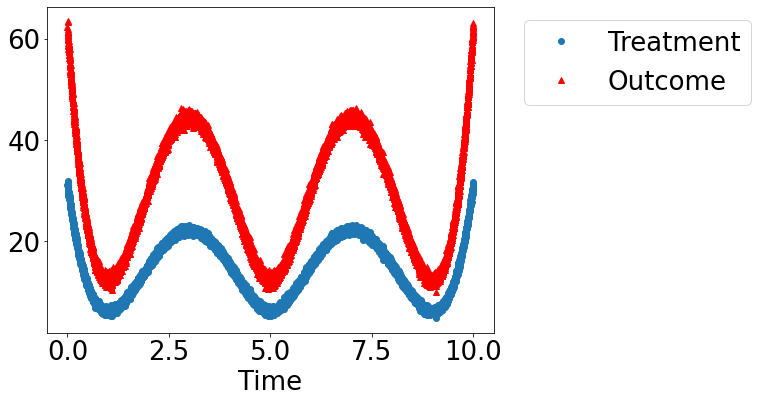

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy.datasets, dowhy.plotter

rvar = 1 if np.random.uniform() > 0.2 else 0
is_linear = False # A non-linear dataset. Change to True to see results for a linear dataset.
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=2,
                                      is_linear=is_linear,
                                      sd_error=0.2)
df = data_dict['df']
print(df.head())
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

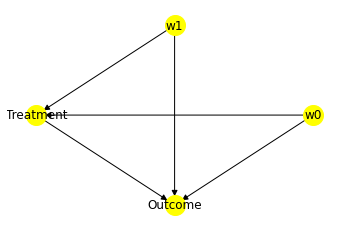

In [14]:
mys_model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
mys_model.view_model(layout="dot")

In [15]:
mys_identified_estimand = mys_model.identify_effect(proceed_when_unidentifiable=True)
print(mys_identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1
Target units: ate

## Estimate
Mean value: 1.998990888422145

Causal Estimate is 1.998990888422145


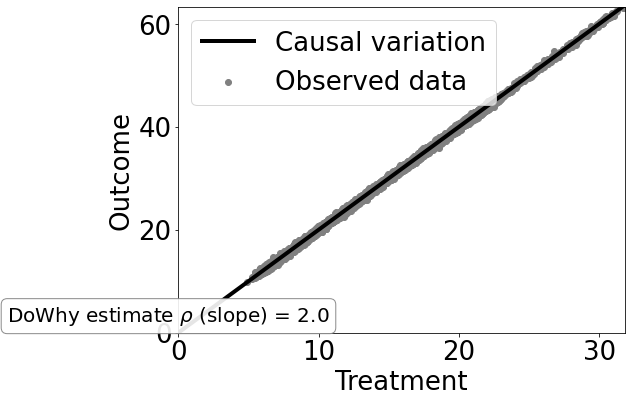

In [16]:
mys_estimate = mys_model.estimate_effect(mys_identified_estimand,
        method_name="backdoor.linear_regression")
print(mys_estimate)
print("Causal Estimate is " + str(mys_estimate.value))

# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(mys_estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

In [17]:
mys_dml_estimate = mys_model.estimate_effect(mys_identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=True)},
                                               "fit_params":{}})
print(mys_dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1 | 
Target units: ate

## Estimate
Mean value: 1.0771029130659606
Effect estimates: [1.07710291 1.07710291 1.07710291 ... 1.07710291 1.07710291 1.07710291]



Conclusion: for non-linear relationships, causal inference with DoubleML obtains a better estimate, which is closer to the causal effect of 1

## A high-level Pandas API

<AxesSubplot:xlabel='v0'>

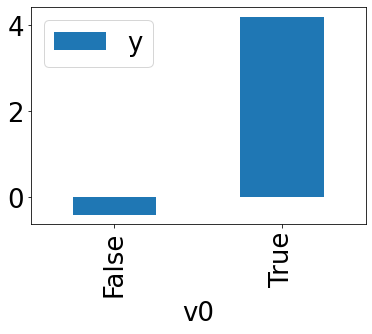

In [18]:
import dowhy.api
import dowhy.datasets

data = dowhy.datasets.linear_dataset(beta=5,
    num_common_causes=1,
    num_instruments = 0,
    num_samples=1000,
    treatment_is_binary=True)

# data['df'] is just a regular pandas.DataFrame
data['df'].causal.do(x='v0', # name of treatment variable
                     variable_types={'v0': 'b', 'y': 'c', 'W0': 'c'},
                     outcome='y',
                     common_causes=['W0']).groupby('v0').mean().plot(y='y', kind='bar')

## Conclusions

* Four steps of causal inference
    * Modelling
    * Identification
    * Estimation
    * Refutation
* DoWhy and EconML integrates causal infernece with machine learning
* DoWhy comes with a Panda API to allow easy-to-access causal inference with data